In [1]:
import os
from glob import glob

from scipy.stats import spearmanr, pearsonr, gaussian_kde
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import sqlite3 as lite 

/tmp/ipykernel_87696/2720191185.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
plt.rcParams["font.family"] = "Arial Narrow"

In [3]:
colors = {
    '0h'  : "#fde725", 
    '1h'  : "#37b578",
    '4h'  : "#21908d",
    '7h'  : "#31668d",
    '10h' : "#43377f",
    '24h' : "#440154",
    'w24h': '#fb8524',
#     'w48h': '#00000080',
}

In [4]:
treatments = ['NUT']
conditions = ['WT']
times = ['0h', '1h', '4h', '7h', '10h', '24h', 'w24h'] #, 'w48h']
replicates = ['1', '2']

In [5]:
db_path = '../../data/ComplementaryData/HiC/TADbit_results/'

In [6]:
cpath = os.path.join(
    db_path, 
    'Cabrera_2022_HCT116_WT_NUT_{}_TR{}/06_segmentation/tads_50kb/{}_*.tsv')

In [7]:
chromosomes = [f'chr{c}' for c in list(range(1, 23)) + ['X']]

In [8]:
tads = {}
for rep in replicates:
    tads[rep] = {}
    for time in times:
        tads[rep][time] = {}
        for c in chromosomes:
            try:
                fh = open(glob(cpath.format(time, rep, c))[0])
            except IndexError:
                print('MISSING:', time, rep, c)
                continue
            tads[rep][time][c] = {}
            next(fh)
            for nl, line in enumerate(fh):
                _, b, e, s, _ = line.split('\t')
                tads[rep][time][c][int(e)] = float(s)

## Fill GAPs

In [9]:
for c in chromosomes:
    chr_end = max(max(tads[rep][time].get(c, {0:0})) for rep in replicates for time in times)
    for rep in replicates:
        for time in times:
            for i in range(chr_end):
                tads[rep][time][c][i] = np.median(tads[rep][time][c].get(i, 0))

## put all into dataframe

In [10]:
headers = []
values = []
for rep in replicates:
    for time in times:
        headers.append("WT:NUT-{} TR{}".format(time, rep))
        values.append([tads[rep][time][c][k] for c in chromosomes for k in sorted(tads[rep][time][c].keys())])

In [11]:
tad_df = pd.DataFrame(np.asarray(values).T, columns=headers)

In [13]:
tad_df = tad_df.loc[~(tad_df==0).all(axis=1)]

In [14]:
tad_df

,WT:NUT-0h TR1,WT:NUT-1h TR1,WT:NUT-4h TR1,WT:NUT-7h TR1,WT:NUT-10h TR1,WT:NUT-24h TR1,WT:NUT-w24h TR1,WT:NUT-0h TR2,WT:NUT-1h TR2,WT:NUT-4h TR2,WT:NUT-7h TR2,WT:NUT-10h TR2,WT:NUT-24h TR2,WT:NUT-w24h TR2
17,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
22,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
27,0.0,0.0,5.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
60744,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0
60745,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
60746,4.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0


In [15]:
tad_df[tad_df > 1] = 1

/tmp/ipykernel_87696/3489032710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tad_df[tad_df > 1] = 1
/tmp/ipykernel_87696/3489032710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tad_df[tad_df > 1] = 1


In [16]:
tad_df

,WT:NUT-0h TR1,WT:NUT-1h TR1,WT:NUT-4h TR1,WT:NUT-7h TR1,WT:NUT-10h TR1,WT:NUT-24h TR1,WT:NUT-w24h TR1,WT:NUT-0h TR2,WT:NUT-1h TR2,WT:NUT-4h TR2,WT:NUT-7h TR2,WT:NUT-10h TR2,WT:NUT-24h TR2,WT:NUT-w24h TR2
17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60744,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
60745,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60746,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [17]:
norm_tads = tad_df.T

In [18]:
norm_tads = StandardScaler().fit_transform(tad_df).T

In [19]:
norm_tads.shape

(14, 8740)

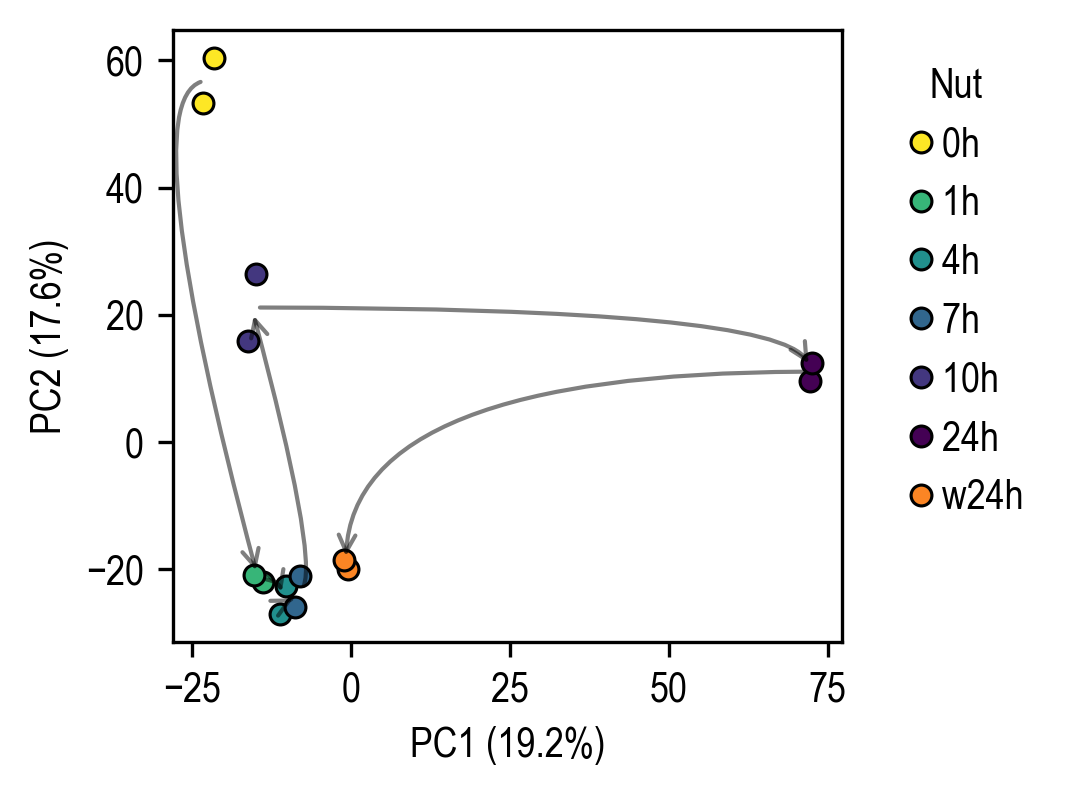

In [20]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_tads)


plt.figure(figsize=(3.7, 2.75),dpi=300)
axe1 = plt.subplot(1, 1, 1)


N = len(headers) // 2

Xs = []
Ys = []
for n, (x, y, _) in enumerate(pca_result):
    color = colors[times[n % len(times)]]
    if n < N:
        axe1.plot(x, y, 'o', color=color, ms=5, label=headers[n][:-3].split("-")[-1], 
                  mec='k', markeredgewidth=0.75)
    else:
        axe1.plot(x, y, 'o', color=color, ms=5, mec='k', markeredgewidth=0.75)
    Xs.append(x)
    Ys.append(y)

    
prevx = (Xs[0] + Xs[0 + N]) / 2
prevy = (Ys[0] + Ys[0 + N]) / 2
for i in range(1, len(headers) // 2):
    avx = (Xs[i] + Xs[i + N]) / 2
    avy = (Ys[i] + Ys[i + N]) / 2
    axe1.annotate(xy=(prevx, prevy), xycoords='data', textcoords='data', xytext=(avx, avy), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=1, alpha=0.5,
                                  connectionstyle="angle3,angleA=-75" if i in [1, 4] else "angle3,angleA=90")
                 )
    prevx = avx
    prevy = avy
    
# axe1.grid()
axe1.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, title='Nut',
           handletextpad=-0.5)
# plt.subplots_adjust(right=0.7)
axe1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.tight_layout()
# plt.savefig("TADs_PCA1vs2_w24h.pdf", dpi=300)
# plt.savefig("TADs_PCA1vs2_w24h.png", dpi=300)

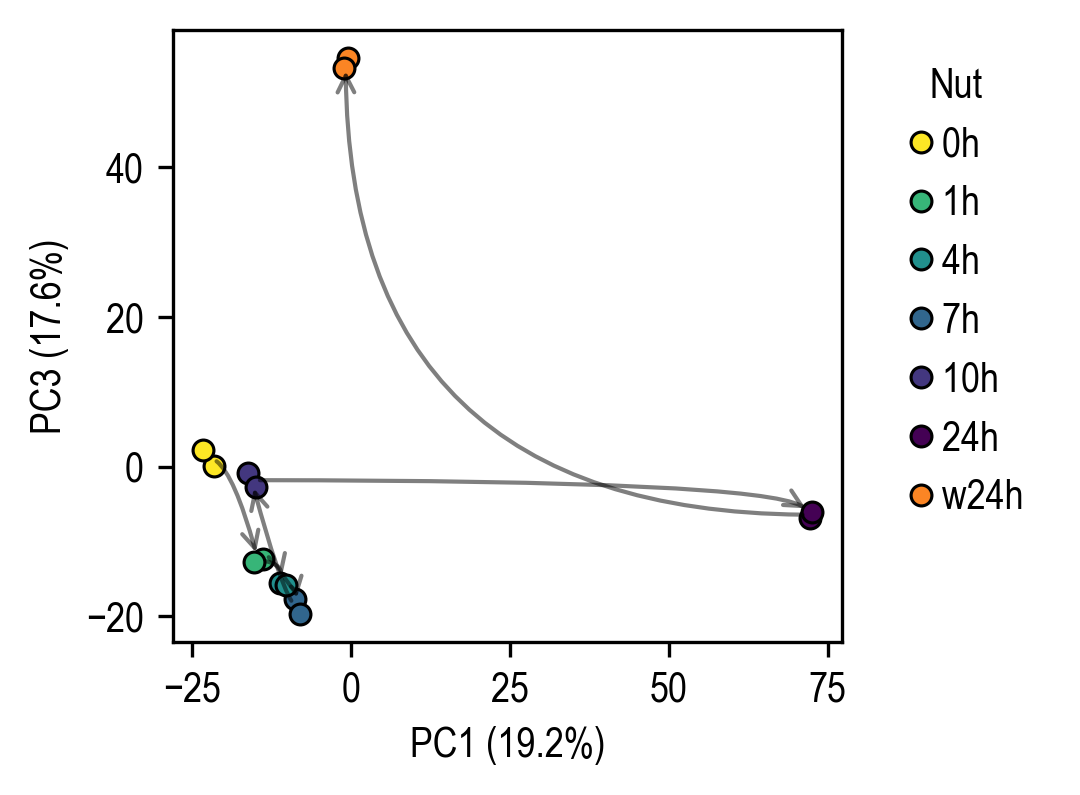

In [21]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_tads)


plt.figure(figsize=(3.7, 2.75),dpi=300)
axe1 = plt.subplot(1, 1, 1)


N = len(headers) // 2

Xs = []
Ys = []
for n, (x, _, y) in enumerate(pca_result):
    color = colors[times[n % len(times)]]
    if n < N:
        axe1.plot(x, y, 'o', color=color, ms=5, label=headers[n][:-3].split("-")[-1], 
                  mec='k', markeredgewidth=0.75)
    else:
        axe1.plot(x, y, 'o', color=color, ms=5, mec='k', markeredgewidth=0.75)
    Xs.append(x)
    Ys.append(y)

    
prevx = (Xs[0] + Xs[0 + N]) / 2
prevy = (Ys[0] + Ys[0 + N]) / 2
for i in range(1, len(headers) // 2):
    avx = (Xs[i] + Xs[i + N]) / 2
    avy = (Ys[i] + Ys[i + N]) / 2
    axe1.annotate(xy=(prevx, prevy), xycoords='data', textcoords='data', xytext=(avx, avy), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=1, alpha=0.5,
                                  connectionstyle="angle3,angleA=-75" if i in [1, 4] else "angle3,angleA=90")
                 )
    prevx = avx
    prevy = avy
    
# axe1.grid()
axe1.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False, title='Nut',
           handletextpad=-0.5)
# plt.subplots_adjust(right=0.7)
axe1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe1.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.tight_layout()
# plt.savefig("Suppl_TADs_PCA1vs3_w24h.pdf", dpi=300)
# plt.savefig("Suppl_TADs_PCA1vs3_w24h.png", dpi=300)

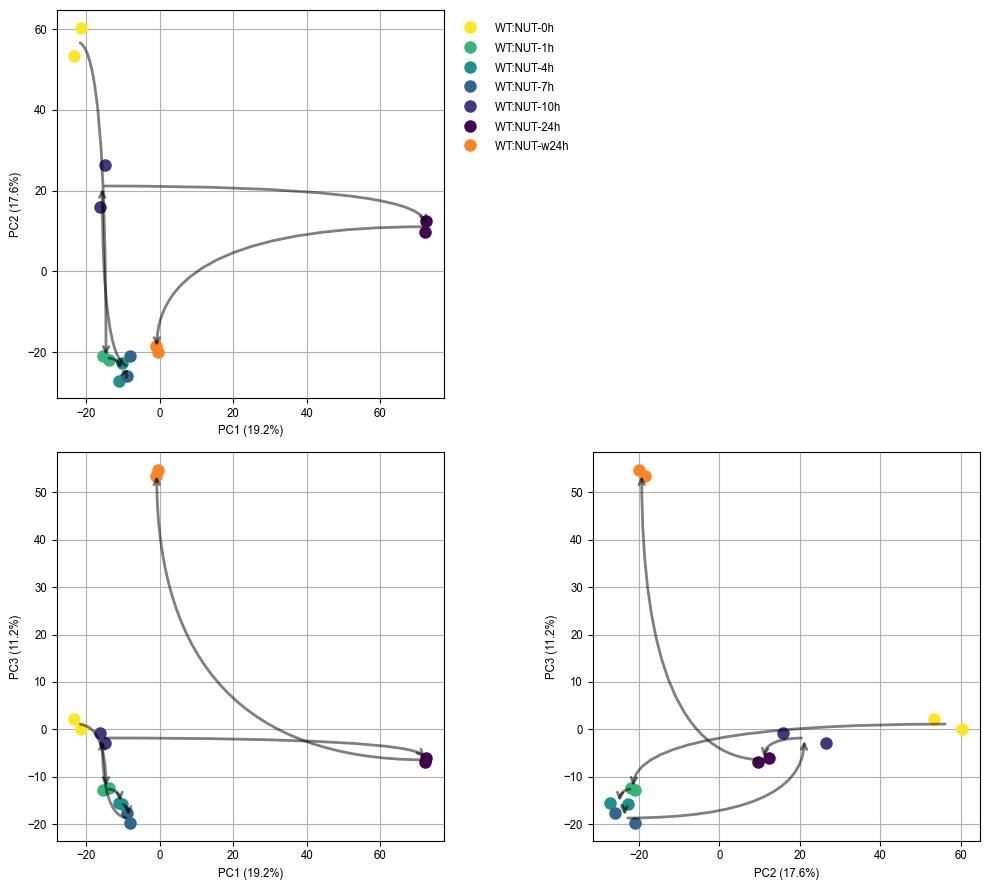

In [22]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(norm_tads)

plt.figure(figsize=(10, 9))
axe1 = plt.subplot(2, 2, 1)
axe2 = plt.subplot(2, 2, 3)
axe3 = plt.subplot(2, 2, 4)

N = len(headers) // 2

Xs = []
Ys = []
Zs = []
for n, (x, y, z) in enumerate(pca_result):
    color = colors[times[n % len(times)]]
    if n < N:
        axe1.plot(x, y, 'o', color=color, ms=8, label=headers[n][:-3])
    else:
        axe1.plot(x, y, 'o', color=color, ms=8)
    axe2.plot(x, z, 'o', color=color, ms=8)
    axe3.plot(y, z, 'o', color=color, ms=8)
    Xs.append(x)
    Ys.append(y)
    Zs.append(z)

    
prevx = (Xs[0] + Xs[0 + N]) / 2
prevy = (Ys[0] + Ys[0 + N]) / 2
prevz = (Zs[0] + Zs[0 + N]) / 2
for i in range(1, len(headers) // 2):
    avx = (Xs[i] + Xs[i + N]) / 2
    avy = (Ys[i] + Ys[i + N]) / 2
    avz = (Zs[i] + Zs[i + N]) / 2
    axe1.annotate(xy=(prevx, prevy), xycoords='data', textcoords='data', xytext=(avx, avy), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=2, alpha=0.5,
                                  connectionstyle="angle3,angleA=90")
                 )
    axe2.annotate(xy=(prevx, prevz), xycoords='data', textcoords='data', xytext=(avx, avz), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=2, alpha=0.5,
                                  connectionstyle="angle3,angleA=90")
                 )
    axe3.annotate(xy=(prevy, prevz), xycoords='data', textcoords='data', xytext=(avy, avz), text="",
                  arrowprops=dict(arrowstyle="<-", linewidth=2, alpha=0.5,
                                  connectionstyle="angle3,angleA=90")
                 )
    prevx = avx
    prevy = avy
    prevz = avz
    
axe1.grid()
axe2.grid()
axe3.grid()
axe1.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
# plt.subplots_adjust(right=0.7)
axe1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axe2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axe2.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
axe3.set_xlabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axe3.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
plt.tight_layout()

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.lines import Line2D

In [25]:
pca = PCA(n_components=10)
pca_result = pca.fit_transform(norm_tads)
print(sum(pca.explained_variance_ratio_))
dmatrix = np.zeros((len(pca_result), len(pca_result)))
for n, w in enumerate(pca.explained_variance_ratio_):
    for i, v1 in enumerate(pca_result[:,n]):
        for j, v2 in enumerate(pca_result[:,n]):
            dmatrix[i][j] += (v2 - v1)**2 * w

dmatrix = dmatrix**0.5

Z = linkage(dmatrix, 'ward', optimal_ordering=True)

0.8774778300296027


/tmp/ipykernel_87696/2827173157.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dmatrix, 'ward', optimal_ordering=True)


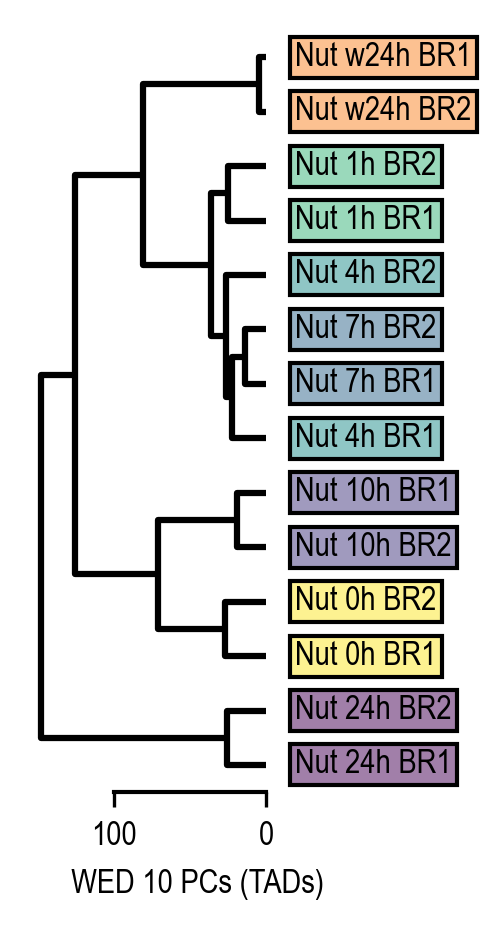

In [26]:
fig = plt.figure(figsize=(1.8, 3.2), dpi=300)
axe = plt.subplot()
axe.set_frame_on(False)
dn = dendrogram(Z, link_color_func=lambda k: 'k', orientation='left')
axe.set_yticklabels([headers[v][3:].replace('-', ' ').replace('UT', 'ut').replace('TR', 'BR') for v in dn['leaves']],
                    rotation=0, size=8)
line = plt.Line2D((axe.get_xticks()[0], axe.get_xticks()[-2]),
                          [0, 0], color='k', lw=1)
line.set_clip_on(False)
axe.add_artist(line)

for n, i in enumerate(dn['leaves']):
    h = headers[i]
    c = [int(colors[h.split('-')[1].split()[0]][1:][i:i+2], 16) / 256 for i in (0, 2, 4)]
    c = tuple(c + [0.5])
    bbox = dict(boxstyle="square", ec=(0, 0, 0, 1), fc=c, 
                alpha=None, pad=0.15)
    plt.setp(axe.get_yticklabels()[n], bbox=bbox)
axe.set_yticklabels(axe.get_yticklabels(), va='center')
axe.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel("             WED 10 PCs (TADs)", size=8, ha = 'center')
plt.tight_layout()
# plt.savefig("TADs_clustering_10PCs_w24h.pdf", dpi=300)